## Pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import glob

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

## Conjuntos de treino e teste

São 904 imagens: 337 de 'Burro' e 567 de 'Capivara'.

São reservados 90% do conjunto para treino e 10% para o conjunto de validação.

In [4]:
size = 150
batch_size = 32
img_height = size
img_width = size

In [5]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
)

Found 904 files belonging to 2 classes.
Using 814 files for training.


In [6]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
)

Found 904 files belonging to 2 classes.
Using 90 files for validation.


In [ ]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(ds_validation))

### Plotando alguns exemplos

Aqui é importante notar que, nesse formato sugerido pelo [tutorial](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset) do Keras, o plot das imagens pedido diretamente ao plt.imshow() retorna uma imagem por batch. No primeiro plot 9x9, conseguimos ver 9 imagens porque temos 26 batchs para treino. Quando pedimos para o conjunto de validação ele só retorna 3 imagens (só temos 3 batchs para validação, apesar das 90 imagens).

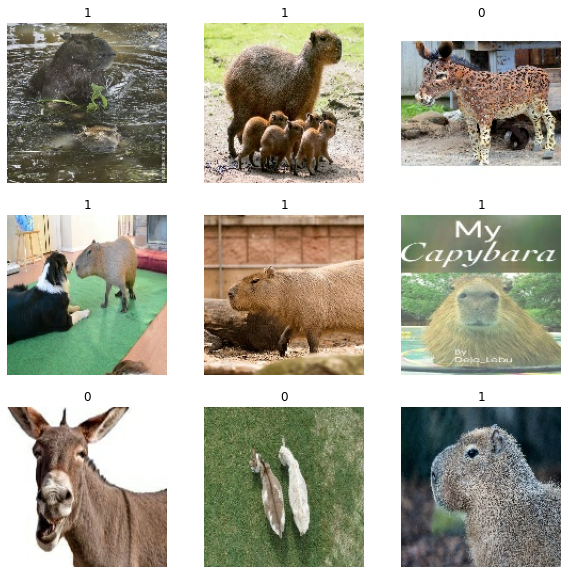

In [6]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0]/255.0)
    plt.title(int(label[0]))
    plt.axis("off")

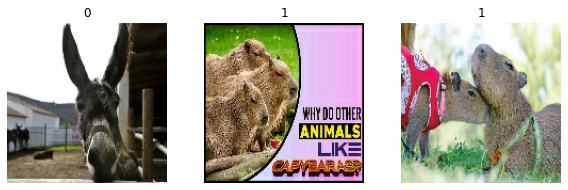

In [51]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_validation.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i]/255.0)
    plt.title(int(label[i]))
    plt.axis("off")

In [9]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(ds_validation))

Number of training samples: 26
Number of validation samples: 3


Para conseguir plotar as imagens de um batch específico é preciso dar 'unbatch' nele usando .unbatch().

Agora conseguimos acessar todas as imagens e plotar elas sem ploblema.

In [7]:
for images, labels in ds_validation:
    print(labels)
    
validation_ds = ds_validation.unbatch()
images = list(validation_ds.map(lambda x, y: x))
labels = list(validation_ds.map(lambda x, y: y))

tf.Tensor([1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0], shape=(26,), dtype=int32)


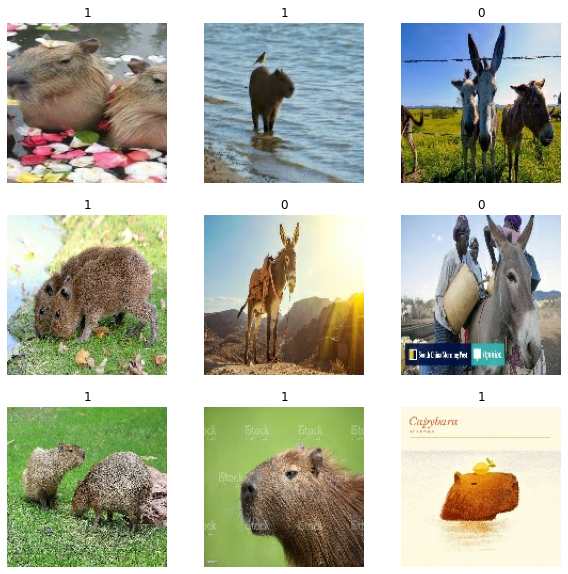

In [58]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(validation_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image/255.0)
    plt.title(int(label))
    plt.axis("off")

## Data augmentations

Agora funciona!

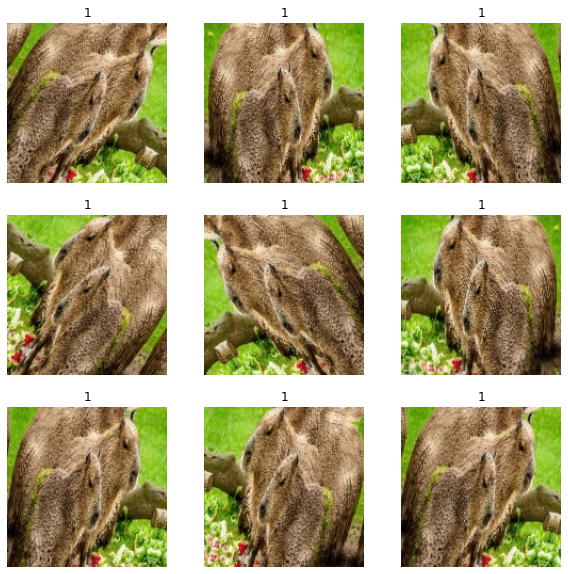

In [61]:
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]/255.0
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0])
        plt.title(int(labels[0]))
        plt.axis("off")

## Construindo o modelo

In [8]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/20
26/26 [==============================] - 50s 1s/step - loss: 0.3872 - binary_accuracy: 0.8084 - val_loss: 0.1893 - val_binary_accuracy: 0.9111
Epoch 2/20
26/26 [==============================] - 38s 1s/step - loss: 0.1728 - binary_accuracy: 0.9324 - val_loss: 0.1433 - val_binary_accuracy: 0.9000
Epoch 3/20
26/26 [==============================] - 38s 1s/step - loss: 0.1252 - binary_accuracy: 0.9533 - val_loss: 0.1272 - val_binary_accuracy: 0.9222
Epoch 4/20
26/26 [==============================] - 38s 1s/step - loss: 0.1192 - binary_accuracy: 0.9509 - val_loss: 0.1225 - val_binary_accuracy: 0.9444
Epoch 5/20
26/26 [==============================] - 38s 1s/step - loss: 0.1070 - binary_accuracy: 0.9558 - val_loss: 0.1184 - val_binary_accuracy: 0.9333
Epoch 6/20
26/26 [==============================] - 38s 1s/step - loss: 0.0961 - binary_accuracy: 0.9693 - val_loss: 0.1224 - val_binary_accuracy: 0.9444
Epoch 7/20
26/26 [==============================] - 39s 2s/step - loss: 0.10

In [10]:
model.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1.h5")
print("Saved model to disk")

C:\Users\malta\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


In [18]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['binary_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

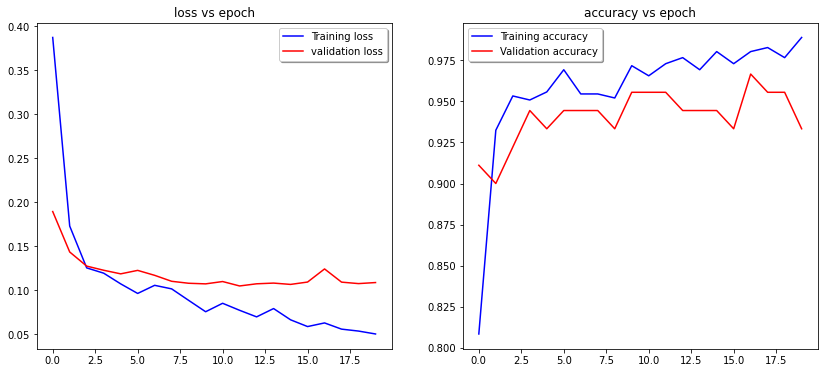

In [19]:
plotLearningCurves(history) 

### Fine tuning

In [20]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_fine = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [21]:
model.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_Fine.h5")
print("Saved model to disk")

C:\Users\malta\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


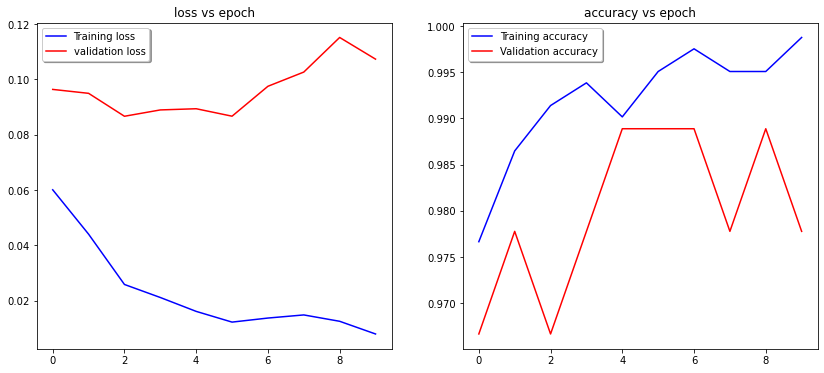

In [22]:
plotLearningCurves(history_fine) 